In [1]:
# =============================================
# Cell 1: Install required packages
# =============================================

!pip install python-louvain scikit-learn networkx matplotlib pandas numpy

In [2]:
# =============================================
# Cell 2: Import all necessary libraries
# =============================================

import zipfile
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import random
from collections import Counter

In [4]:
# =============================================
# Cell 3: Mount Google Drive (if using colab)
# =============================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# If your file is in Google Drive, adjust this path
zip_file_path = '/content/drive/MyDrive/Facebook social.zip'
# If it's uploaded directly to colab, use:
# zip_file_path = '/content/Facebook social.zip'

Mounted at /content/drive


In [5]:
# =============================================
# Cell 4: Unzip and load the dataset
# =============================================

import zipfile
import os

# Path setup
zip_file_path = '/content/Facebook social.zip'  # Adjust if needed
output_dir = '/content/facebook_social_data'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Unzip if not already done
if not os.path.exists(os.path.join(output_dir, 'Facebook social')):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

print(f"Unzipped to: {output_dir}")

# Explore directory structure
def explore_directory(path, level=0):
    items = os.listdir(path)
    for item in items[:10]:  # Show first 10 items
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print("  " * level + f"📁 {item}/")
            explore_directory(full_path, level + 1)
        else:
            print("  " * level + f"📄 {item}")

explore_directory(output_dir)

Unzipped to: /content/facebook_social_data
📁 Facebook social/
  📁 facebook/
    📄 414.egofeat
    📄 698.featnames
    📄 3437.featnames
    📄 1684.circles
    📄 698.feat
    📄 414.featnames
    📄 1912.egofeat
    📄 0.egofeat
    📄 348.edges
    📄 1912.feat


In [6]:
# =============================================
# Cell 5: Load and preprocess edge data
# =============================================

import glob

# Find all .edges files
facebook_data_path = os.path.join(output_dir, 'Facebook social/facebook')
edges_files = glob.glob(os.path.join(facebook_data_path, '*.edges'))

print(f"Found {len(edges_files)} .edges files")

# Read and combine all edges
all_edges = []
for file_path in edges_files:
    try:
        df_edges = pd.read_csv(file_path, sep=' ', header=None, names=['node1', 'node2'])
        all_edges.append(df_edges)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Combine and clean edges
if all_edges:
    edges_df = pd.concat(all_edges, ignore_index=True)
    print(f"Total raw edges loaded: {len(edges_df)}")

    # Remove duplicates and ensure undirected edges
    edges_df['node1_sorted'] = edges_df[['node1', 'node2']].min(axis=1)
    edges_df['node2_sorted'] = edges_df[['node1', 'node2']].max(axis=1)
    edges_df = edges_df.drop_duplicates(subset=['node1_sorted', 'node2_sorted']).drop(columns=['node1_sorted', 'node2_sorted'])

    print(f"Total unique undirected edges: {len(edges_df)}")
    print(f"Number of unique nodes: {len(set(edges_df['node1']).union(set(edges_df['node2'])))}")
else:
    print("No edges files found")
    edges_df = pd.DataFrame(columns=['node1', 'node2'])

# Display sample
print("\nSample edges:")
print(edges_df.head())

Found 10 .edges files
Total raw edges loaded: 170174
Total unique undirected edges: 84243
Number of unique nodes: 3959

Sample edges:
   node1  node2
0    436    428
1    450    531
2    538    404
3    565    412
4    471    461


In [8]:
# =============================================
# Cell 6: Load feature files (if available)
# =============================================

# Check for feature files
feat_files = glob.glob(os.path.join(facebook_data_path, '*.feat'))
featnames_files = glob.glob(os.path.join(facebook_data_path, '*.featnames'))

print(f"Found {len(feat_files)} .feat files")
print(f"Found {len(featnames_files)} .featnames files")

# Try to load one .featnames to understand feature structure
if featnames_files:
    sample_featnames = featnames_files[0]
    with open(sample_featnames, 'r') as f:
        feature_names = [line.strip() for line in f.readlines()[:10]]  # First 10
    print(f"\nSample feature names from {os.path.basename(sample_featnames)}:")
    for i, name in enumerate(feature_names):
        print(f"  {i}: {name}")

Found 10 .feat files
Found 10 .featnames files

Sample feature names from 698.featnames:
  0: 0 birthday;anonymized feature 2
  1: 1 birthday;anonymized feature 3
  2: 2 education;classes;id;anonymized feature 335
  3: 3 education;classes;id;anonymized feature 336
  4: 4 education;concentration;id;anonymized feature 14
  5: 5 education;degree;id;anonymized feature 22
  6: 6 education;school;id;anonymized feature 340
  7: 7 education;school;id;anonymized feature 341
  8: 8 education;school;id;anonymized feature 369
  9: 9 education;school;id;anonymized feature 342


In [9]:
# =============================================
# Cell 7: Create the social network graph
# =============================================

# Create undirected graph
G_original = nx.from_pandas_edgelist(edges_df, 'node1', 'node2')
print(f"Original Graph:")
print(f"  Number of nodes: {G_original.number_of_nodes()}")
print(f"  Number of edges: {G_original.number_of_edges()}")
print(f"  Is connected: {nx.is_connected(G_original)}")

# Get largest connected component
if not nx.is_connected(G_original):
    largest_cc = max(nx.connected_components(G_original), key=len)
    G_original = G_original.subgraph(largest_cc).copy()
    print(f"\nLargest Connected Component:")
    print(f"  Number of nodes: {G_original.number_of_nodes()}")
    print(f"  Number of edges: {G_original.number_of_edges()}")

Original Graph:
  Number of nodes: 3959
  Number of edges: 84243
  Is connected: False

Largest Connected Component:
  Number of nodes: 3927
  Number of edges: 84210


In [10]:
# =============================================
# Cell 8: Compute graph metrics for all nodes
# =============================================

print("Computing graph metrics...")

# 1. Degree
degrees = dict(G_original.degree())
print(f"✓ Node degrees computed")

# 2. Clustering coefficient
clustering = nx.clustering(G_original)
print(f"✓ Clustering coefficients computed")

# 3. Betweenness centrality (sample for speed)
nodes_list = list(G_original.nodes())
sampled_nodes = random.sample(nodes_list, min(500, len(nodes_list)))
betweenness = nx.betweenness_centrality(G_original, k=len(sampled_nodes), normalized=True, seed=42)
print(f"✓ Betweenness centrality computed (sampled)")

# 4. Closeness centrality (sample for speed)
closeness = nx.closeness_centrality(G_original)
print(f"✓ Closeness centrality computed")

# 5. PageRank
pagerank = nx.pagerank(G_original, alpha=0.85)
print(f"✓ PageRank computed")

# 6. Eigenvector centrality
try:
    eigenvector = nx.eigenvector_centrality(G_original, max_iter=1000)
    print(f"✓ Eigenvector centrality computed")
except:
    eigenvector = {node: 0 for node in G_original.nodes()}
    print(f"✗ Eigenvector centrality failed, using zeros")

# 7. Community detection using Louvain
try:
    import community as community_louvain
    partition = community_louvain.best_partition(G_original)
    print(f"✓ Community detection completed")
except:
    # Fallback: simple community assignment
    partition = {node: 0 for node in G_original.nodes()}
    print(f"✗ Community detection failed, using single community")

Computing graph metrics...
✓ Node degrees computed
✓ Clustering coefficients computed
✓ Betweenness centrality computed (sampled)
✓ Closeness centrality computed
✓ PageRank computed
✓ Eigenvector centrality computed
✗ Community detection failed, using single community


In [11]:
# =============================================
# Cell 9: Create feature DataFrame
# =============================================

# Create DataFrame with all features
node_features = pd.DataFrame(index=G_original.nodes())
node_features['degree'] = pd.Series(degrees)
node_features['clustering'] = pd.Series(clustering)
node_features['betweenness'] = pd.Series(betweenness)
node_features['closeness'] = pd.Series(closeness)
node_features['pagerank'] = pd.Series(pagerank)
node_features['eigenvector'] = pd.Series(eigenvector)
node_features['community'] = pd.Series(partition)

# Add some derived features
node_features['degree_log'] = np.log1p(node_features['degree'])
node_features['clustering_scaled'] = (node_features['clustering'] - node_features['clustering'].mean()) / node_features['clustering'].std()

print(f"Feature matrix shape: {node_features.shape}")
print("\nFeature statistics:")
print(node_features.describe())

Feature matrix shape: (3927, 9)

Feature statistics:
            degree   clustering  betweenness    closeness     pagerank  \
count  3927.000000  3927.000000  3927.000000  3927.000000  3927.000000   
mean     42.887701     0.544949     0.001149     0.187607     0.000255   
std      46.340160     0.229383     0.007002     0.033656     0.000135   
min       1.000000     0.000000     0.000000     0.088822     0.000041   
25%      11.000000     0.397278     0.000008     0.165330     0.000157   
50%      25.000000     0.544335     0.000064     0.191690     0.000236   
75%      57.000000     0.698495     0.000390     0.211002     0.000327   
max     293.000000     1.000000     0.245547     0.273151     0.001371   

        eigenvector  community   degree_log  clustering_scaled  
count  3.927000e+03     3927.0  3927.000000       3.927000e+03  
mean   3.835791e-03        0.0     3.243796      -1.592253e-16  
std    1.549178e-02        0.0     1.096428       1.000000e+00  
min    1.037464e-19 

In [12]:
# =============================================
# Cell 10: Create realistic bot labels
# =============================================

print("Creating realistic bot labels...")

# Method 1: Based on graph metrics (bots have specific patterns)
def create_bot_labels_based_on_metrics(df, bot_ratio=0.15):
    """Create bot labels based on anomalous patterns in graph metrics"""

    # Bots often have:
    # 1. High degree but low clustering (fake followers)
    # 2. High betweenness but low eigenvector centrality (bridge spammers)
    # 3. Unusual combinations of metrics

    # Calculate anomaly scores
    df['degree_z'] = (df['degree'] - df['degree'].mean()) / df['degree'].std()
    df['clustering_z'] = (df['clustering'] - df['clustering'].mean()) / df['clustering'].std()
    df['betweenness_z'] = (df['betweenness'] - df['betweenness'].mean()) / df['betweenness'].std()

    # Anomaly score (higher = more bot-like)
    # Bots: high degree, low clustering, medium-high betweenness
    df['anomaly_score'] = (
        np.abs(df['degree_z']) * 0.4 +
        np.abs(df['clustering_z']) * 0.3 +
        np.abs(df['betweenness_z']) * 0.3
    )

    # Identify top anomalies as bots
    n_bots = int(len(df) * bot_ratio)
    bot_indices = df.nlargest(n_bots, 'anomaly_score').index

    # Create labels
    labels = pd.Series(0, index=df.index)
    labels.loc[bot_indices] = 1

    return labels, df['anomaly_score']

# Method 2: Random but with some patterns
def create_bot_labels_synthetic(df, bot_ratio=0.15):
    """Create synthetic bot labels with some patterns"""
    n_nodes = len(df)
    n_bots = int(n_nodes * bot_ratio)

    # Initialize all as non-bots
    labels = np.zeros(n_nodes, dtype=int)

    # Select bots based on some criteria
    # Criterion 1: Very high degree nodes (potential fake accounts)
    high_degree_threshold = df['degree'].quantile(0.95)
    high_degree_nodes = df[df['degree'] >= high_degree_threshold].index.tolist()

    # Criterion 2: Very low clustering nodes (suspicious)
    low_clustering_threshold = df['clustering'].quantile(0.05)
    low_clustering_nodes = df[df['clustering'] <= low_clustering_threshold].index.tolist()

    # Combine criteria
    potential_bots = list(set(high_degree_nodes + low_clustering_nodes))

    # If not enough, add random nodes
    if len(potential_bots) < n_bots:
        remaining = n_bots - len(potential_bots)
        other_nodes = [n for n in df.index if n not in potential_bots]
        additional_bots = random.sample(other_nodes, min(remaining, len(other_nodes)))
        potential_bots.extend(additional_bots)

    # Ensure we have exactly n_bots
    if len(potential_bots) > n_bots:
        potential_bots = random.sample(potential_bots, n_bots)

    # Assign labels
    for node in potential_bots:
        labels[df.index.get_loc(node)] = 1

    return pd.Series(labels, index=df.index)

# Create labels using synthetic method
node_features['is_bot'] = create_bot_labels_synthetic(node_features, bot_ratio=0.12)

print(f"Bot distribution:")
print(f"  Total nodes: {len(node_features)}")
print(f"  Bots: {node_features['is_bot'].sum()} ({node_features['is_bot'].mean()*100:.1f}%)")
print(f"  Non-bots: {(node_features['is_bot'] == 0).sum()}")

# Check feature differences
print("\nMean feature values by class:")
bot_features = node_features[node_features['is_bot'] == 1]
nonbot_features = node_features[node_features['is_bot'] == 0]

for col in ['degree', 'clustering', 'betweenness', 'closeness']:
    print(f"{col}:")
    print(f"  Bots: {bot_features[col].mean():.4f}")
    print(f"  Non-bots: {nonbot_features[col].mean():.4f}")

Creating realistic bot labels...
Bot distribution:
  Total nodes: 3927
  Bots: 471 (12.0%)
  Non-bots: 3456

Mean feature values by class:
degree:
  Bots: 85.9936
  Non-bots: 37.0130
clustering:
  Bots: 0.3835
  Non-bots: 0.5670
betweenness:
  Bots: 0.0021
  Non-bots: 0.0010
closeness:
  Bots: 0.1904
  Non-bots: 0.1872


In [13]:
# =============================================
# Cell 11: Train baseline bot detection model
# =============================================

print("Training baseline bot detection model...")

# Prepare features and labels
X = node_features.drop('is_bot', axis=1)
y = node_features['is_bot']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples ({y_train.mean()*100:.1f}% bots)")
print(f"Test set: {X_test.shape[0]} samples ({y_test.mean()*100:.1f}% bots)")

# Handle class imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = rf_baseline.predict(X_train_scaled)
y_pred_test = rf_baseline.predict(X_test_scaled)
y_pred_proba_test = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluation
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation")
    print(f"{'='*60}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(f"[[TN:{cm[0,0]:3d}  FP:{cm[0,1]:3d}]")
    print(f" [FN:{cm[1,0]:3d}  TP:{cm[1,1]:3d}]]")

    if y_pred_proba is not None:
        from sklearn.metrics import roc_auc_score
        try:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
            print(f"ROC-AUC:   {roc_auc:.4f}")
        except:
            print("ROC-AUC:   Could not compute")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Evaluate baseline
baseline_metrics = evaluate_model(y_test, y_pred_test, y_pred_proba_test, "Baseline Model")

# Store results for comparison
all_results = {'Baseline': baseline_metrics}

Training baseline bot detection model...
Training set: 2748 samples (12.0% bots)
Test set: 1179 samples (12.0% bots)

Baseline Model Evaluation
Accuracy:  0.9822
Precision: 1.0000
Recall:    0.8511
F1-Score:  0.9195

Confusion Matrix:
[[TN:1038  FP:  0]
 [FN: 21  TP:120]]
ROC-AUC:   0.9096


In [15]:
# =============================================
# Cell 12: Function to simulate structural evasion attack
# =============================================

def apply_structural_evasion_attack(G, bot_nodes, node_features, attack_strength=0.1):
    """
    Simulate structural evasion attack where bots modify their connections
    to appear more like normal nodes.

    Args:
        G: NetworkX graph
        bot_nodes: List of bot node IDs
        node_features: DataFrame with node features
        attack_strength: Fraction of edges to modify (0-1)

    Returns:
        G_evaded: Modified graph
        modifications: List of modifications made
    """
    print(f"\nApplying structural evasion attack...")
    print(f"Number of bots: {len(bot_nodes)}")
    print(f"Attack strength: {attack_strength}")

    # Create a copy of the original graph
    G_evaded = G.copy()
    modifications = []

    # Get average features of non-bots for reference
    nonbot_nodes = [n for n in G.nodes() if n not in bot_nodes]
    avg_nonbot_degree = np.mean([G.degree(n) for n in nonbot_nodes])
    avg_nonbot_neighbors = set()

    # Sample non-bot nodes for connections
    nonbot_samples = random.sample(nonbot_nodes, min(100, len(nonbot_nodes)))

    for bot in bot_nodes:
        # Current bot features
        bot_degree = G.degree(bot)

        # Strategy 1: Add connections to non-bots to appear normal
        # Target degree closer to average
        target_degree = int(avg_nonbot_degree * (1 + random.uniform(-0.2, 0.2)))
        degree_diff = target_degree - bot_degree

        if degree_diff > 0:
            # Bot needs more connections
            possible_new_connections = [n for n in nonbot_samples if n != bot and not G_evaded.has_edge(bot, n)]
            n_new_edges = min(int(degree_diff * attack_strength), len(possible_new_connections))

            if n_new_edges > 0:
                new_connections = random.sample(possible_new_connections, n_new_edges)
                for target in new_connections:
                    G_evaded.add_edge(bot, target)
                    modifications.append(('add', bot, target))

        elif degree_diff < 0:
            # Bot has too many connections, remove some
            current_neighbors = list(G_evaded.neighbors(bot))
            if current_neighbors:
                n_remove = min(int(abs(degree_diff) * attack_strength), len(current_neighbors))
                to_remove = random.sample(current_neighbors, n_remove)
                for target in to_remove:
                    G_evaded.remove_edge(bot, target)
                    modifications.append(('remove', bot, target))

        # Strategy 2: Connect to other bots to form clusters (evade clustering-based detection)
        if random.random() < 0.3:  # 30% of bots try this
            other_bots = [b for b in bot_nodes if b != bot and not G_evaded.has_edge(bot, b)]
            if other_bots:
                n_cluster_edges = min(2, len(other_bots))
                cluster_connections = random.sample(other_bots, n_cluster_edges)
                for target in cluster_connections:
                    G_evaded.add_edge(bot, target)
                    modifications.append(('add_bot_cluster', bot, target))

    print(f"Total modifications: {len(modifications)}")
    print(f"  Added edges: {len([m for m in modifications if m[0] in ['add', 'add_bot_cluster']])}")
    print(f"  Removed edges: {len([m for m in modifications if m[0] == 'remove'])}")

    return G_evaded, modifications

In [17]:
# =============================================
# Cell 13: Apply structural evasion attack and re-evaluate
# =============================================

# Identify bot nodes
bot_nodes = node_features[node_features['is_bot'] == 1].index.tolist()

# Apply evasion attack
G_evaded, evasion_mods = apply_structural_evasion_attack(
    G_original,
    bot_nodes,
    node_features,
    attack_strength=0.15
)

print(f"\nGraph after evasion attack:")
print(f"  Nodes: {G_evaded.number_of_nodes()}")
print(f"  Edges: {G_evaded.number_of_edges()}")
print(f"  Edge change: {G_evaded.number_of_edges() - G_original.number_of_edges()}")

# Recompute features for evaded graph
print("\nRecomputing features after evasion...")

# Compute metrics for evaded graph
degrees_evaded = dict(G_evaded.degree())
clustering_evaded = nx.clustering(G_evaded)
betweenness_evaded = nx.betweenness_centrality(G_evaded, k=500, normalized=True, seed=42)
closeness_evaded = nx.closeness_centrality(G_evaded)
pagerank_evaded = nx.pagerank(G_evaded, alpha=0.85)

# Recompute Eigenvector centrality for the evaded graph
try:
    eigenvector_evaded = nx.eigenvector_centrality(G_evaded, max_iter=1000)
    print(f"\u2713 Eigenvector centrality computed for evaded graph")
except:
    eigenvector_evaded = {node: 0 for node in G_evaded.nodes()}
    print(f"\u2717 Eigenvector centrality failed for evaded graph, using zeros")

# Create new feature DataFrame
node_features_evaded = pd.DataFrame(index=G_evaded.nodes())
node_features_evaded['degree'] = pd.Series(degrees_evaded)
node_features_evaded['clustering'] = pd.Series(clustering_evaded)
node_features_evaded['betweenness'] = pd.Series(betweenness_evaded)
node_features_evaded['closeness'] = pd.Series(closeness_evaded)
node_features_evaded['pagerank'] = pd.Series(pagerank_evaded)
node_features_evaded['eigenvector'] = pd.Series(eigenvector_evaded) # Add eigenvector here
node_features_evaded['community'] = node_features['community']  # Keep same communities

# Add derived features
node_features_evaded['degree_log'] = np.log1p(node_features_evaded['degree'])
node_features_evaded['clustering_scaled'] = (node_features_evaded['clustering'] - node_features_evaded['clustering'].mean()) / node_features_evaded['clustering'].std()

# Keep same labels
node_features_evaded['is_bot'] = node_features['is_bot']

# Prepare features for evaluation
X_evaded = node_features_evaded.drop('is_bot', axis=1)
y_evaded = node_features_evaded['is_bot']

# Split (same indices as before for fair comparison)
train_indices = X_train.index
test_indices = X_test.index

X_train_evaded = X_evaded.loc[train_indices]
X_test_evaded = X_evaded.loc[test_indices]
y_train_evaded = y_evaded.loc[train_indices]
y_test_evaded = y_evaded.loc[test_indices]

# Scale
X_train_evaded_scaled = scaler.transform(X_train_evaded)
X_test_evaded_scaled = scaler.transform(X_test_evaded)

# Train new model on evaded graph
rf_evaded = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)

rf_evaded.fit(X_train_evaded_scaled, y_train_evaded)

# Evaluate
y_pred_evaded = rf_evaded.predict(X_test_evaded_scaled)
y_pred_proba_evaded = rf_evaded.predict_proba(X_test_evaded_scaled)[:, 1]

evasion_metrics = evaluate_model(y_test_evaded, y_pred_evaded, y_pred_proba_evaded, "After Evasion Attack")

# Store results
all_results['After Evasion'] = evasion_metrics

# Also test original model on evaded graph (to see if bots successfully evade)
print("\n" + "="*60)
print("Testing ORIGINAL model on EVADED graph (detection evasion test)")
print("="*60)

y_pred_original_on_evaded = rf_baseline.predict(X_test_evaded_scaled)
evasion_success_metrics = evaluate_model(y_test_evaded, y_pred_original_on_evaded, None, "Original Model on Evaded Graph")

# Calculate evasion success rate
original_detected = sum(y_pred_original_on_evaded[y_test_evaded == 1])
evaded_detected = sum(y_pred_evaded[y_test_evaded == 1])
total_bots = sum(y_test_evaded == 1)

evasion_success_rate = 1 - (evaded_detected / original_detected if original_detected > 0 else 0)
print(f"\nEvasion Success Analysis:")
print(f"  Bots detected by original model: {original_detected}/{total_bots}")
print(f"  Bots detected after evasion: {evaded_detected}/{total_bots}")
print(f"  Evasion success rate: {evasion_success_rate:.2%}")


Applying structural evasion attack...
Number of bots: 471
Attack strength: 0.15
Total modifications: 5606
  Added edges: 1189
  Removed edges: 4417

Graph after evasion attack:
  Nodes: 3927
  Edges: 80982
  Edge change: -3228

Recomputing features after evasion...
✓ Eigenvector centrality computed for evaded graph

After Evasion Attack Evaluation
Accuracy:  0.9644
Precision: 0.8367
Recall:    0.8723
F1-Score:  0.8542

Confusion Matrix:
[[TN:1014  FP: 24]
 [FN: 18  TP:123]]
ROC-AUC:   0.9815

Testing ORIGINAL model on EVADED graph (detection evasion test)

Original Model on Evaded Graph Evaluation
Accuracy:  0.9474
Precision: 0.8762
Recall:    0.6525
F1-Score:  0.7480

Confusion Matrix:
[[TN:1025  FP: 13]
 [FN: 49  TP: 92]]

Evasion Success Analysis:
  Bots detected by original model: 92/141
  Bots detected after evasion: 123/141
  Evasion success rate: -33.70%


In [18]:
# =============================================
# Cell 14: Function to simulate graph poisoning attack
# =============================================

def apply_graph_poisoning_attack(G, node_features, poisoning_ratio=0.1):
    """
    Simulate graph poisoning attack by injecting fake bot nodes.

    Args:
        G: Original NetworkX graph
        node_features: DataFrame with original node features
        poisoning_ratio: Fraction of nodes to add as poison

    Returns:
        G_poisoned: Graph with poisoned nodes
        node_features_poisoned: Updated features with poisoned nodes
        poison_nodes: List of added poison node IDs
    """
    print(f"\nApplying graph poisoning attack...")

    # Create a copy of the original graph
    G_poisoned = G.copy()

    # Determine number of poison nodes to add
    n_original_nodes = G.number_of_nodes()
    n_poison_nodes = int(n_original_nodes * poisoning_ratio)

    # Generate poison nodes
    max_node_id = max(G.nodes())
    poison_nodes = list(range(max_node_id + 1, max_node_id + n_poison_nodes + 1))

    print(f"Adding {n_poison_nodes} poison nodes (ID: {poison_nodes[0]} to {poison_nodes[-1]})")

    # Add poison nodes to graph
    G_poisoned.add_nodes_from(poison_nodes)

    # Strategy 1: Connect poison nodes to each other (botnet formation)
    for i in range(len(poison_nodes)):
        # Connect to 1-3 other poison nodes
        n_connections = random.randint(1, 3)
        possible_connections = poison_nodes[i+1:min(i+1+n_connections, len(poison_nodes))]
        for target in possible_connections:
            G_poisoned.add_edge(poison_nodes[i], target)

    # Strategy 2: Connect poison nodes to real nodes (infiltration)
    real_nodes = list(G.nodes())

    for poison_node in poison_nodes:
        # Connect to 3-8 real nodes
        n_real_connections = random.randint(3, 8)
        targets = random.sample(real_nodes, min(n_real_connections, len(real_nodes)))

        for target in targets:
            G_poisoned.add_edge(poison_node, target)

    print(f"Graph after poisoning:")
    print(f"  Nodes: {G_poisoned.number_of_nodes()} (+{n_poison_nodes})")
    print(f"  Edges: {G_poisoned.number_of_edges()}")

    # Create features for poison nodes
    print("\nGenerating features for poison nodes...")

    # Compute metrics for poisoned graph
    degrees_poisoned = dict(G_poisoned.degree())
    clustering_poisoned = nx.clustering(G_poisoned)

    # Only compute centrality for a sample (for speed)
    sample_size = min(800, G_poisoned.number_of_nodes())
    sampled_nodes = random.sample(list(G_poisoned.nodes()), sample_size)
    betweenness_poisoned = nx.betweenness_centrality(G_poisoned, k=sample_size, normalized=True, seed=42)
    closeness_poisoned = nx.closeness_centrality(G_poisoned)
    pagerank_poisoned = nx.pagerank(G_poisoned, alpha=0.85)

    # Create feature DataFrame for all nodes
    node_features_poisoned = pd.DataFrame(index=G_poisoned.nodes())
    node_features_poisoned['degree'] = pd.Series(degrees_poisoned)
    node_features_poisoned['clustering'] = pd.Series(clustering_poisoned)
    node_features_poisoned['betweenness'] = pd.Series(betweenness_poisoned)
    node_features_poisoned['closeness'] = pd.Series(closeness_poisoned)
    node_features_poisoned['pagerank'] = pd.Series(pagerank_poisoned)

    # Assign communities (simplified - poison nodes get new community IDs)
    # Original nodes keep their communities
    original_communities = node_features['community']
    node_features_poisoned.loc[original_communities.index, 'community'] = original_communities

    # Assign new community IDs to poison nodes
    max_community = original_communities.max() if not original_communities.empty else 0
    for i, node in enumerate(poison_nodes):
        node_features_poisoned.loc[node, 'community'] = max_community + 1 + (i % 3)  # 3 new communities

    # Fill NaN values
    node_features_poisoned['community'] = node_features_poisoned['community'].fillna(-1)

    # Add derived features
    node_features_poisoned['degree_log'] = np.log1p(node_features_poisoned['degree'])
    node_features_poisoned['clustering_scaled'] = (node_features_poisoned['clustering'] - node_features_poisoned['clustering'].mean()) / node_features_poisoned['clustering'].std()

    # Label poison nodes as bots (1) and original nodes keep their labels
    node_features_poisoned['is_bot'] = 0
    node_features_poisoned.loc[original_communities.index, 'is_bot'] = node_features['is_bot']
    node_features_poisoned.loc[poison_nodes, 'is_bot'] = 1

    print(f"Poison nodes labeled as bots: {sum(node_features_poisoned.loc[poison_nodes, 'is_bot'])}")
    print(f"Total bots after poisoning: {node_features_poisoned['is_bot'].sum()}")

    return G_poisoned, node_features_poisoned, poison_nodes

In [20]:
# =============================================
# Cell 15: Apply graph poisoning attack and re-evaluate
# =============================================

# Apply poisoning attack
G_poisoned, node_features_poisoned, poison_nodes = apply_graph_poisoning_attack(
    G_original,
    node_features,
    poisoning_ratio=0.15  # Add 15% poison nodes
)

# Prepare features for poisoned graph
X_poisoned = node_features_poisoned.drop('is_bot', axis=1)
y_poisoned = node_features_poisoned['is_bot']

# Split data (include poison nodes in training to simulate poisoning during training)
# We'll split differently: 70% train, 30% test, but ensure poison nodes are in train
original_indices = list(G_original.nodes())
poison_indices = poison_nodes

# Original nodes split (same as before for fair comparison)
original_train_indices = [idx for idx in train_indices if idx in original_indices]
original_test_indices = [idx for idx in test_indices if idx in original_indices]

# Add all poison nodes to training (poisoning attack)
train_indices_poisoned = list(original_train_indices) + poison_indices
test_indices_poisoned = list(original_test_indices)

print(f"\nTraining set after poisoning: {len(train_indices_poisoned)} nodes")
print(f"  Original nodes in train: {len(original_train_indices)}")
print(f"  Poison nodes in train: {len(poison_indices)}")
print(f"Test set: {len(test_indices_poisoned)} nodes (original only)")

# Get corresponding data
X_train_poisoned = X_poisoned.loc[train_indices_poisoned]
X_test_poisoned = X_poisoned.loc[test_indices_poisoned]
y_train_poisoned = y_poisoned.loc[train_indices_poisoned]
y_test_poisoned = y_poisoned.loc[test_indices_poisoned]

print(f"\nClass distribution in poisoned training:")
print(f"  Bots: {y_train_poisoned.sum()}/{len(y_train_poisoned)} ({y_train_poisoned.mean()*100:.1f}%)者に")
print(f"  Non-bots: {len(y_train_poisoned) - y_train_poisoned.sum()}")

# Scale features
scaler_poisoned = StandardScaler()
X_train_poisoned_scaled = scaler_poisoned.fit_transform(X_train_poisoned)
X_test_poisoned_scaled = scaler_poisoned.transform(X_test_poisoned)

# Compute class weights for poisoned data
class_weights_poisoned = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_poisoned),
    y=y_train_poisoned
)
class_weight_dict_poisoned = {0: class_weights_poisoned[0], 1: class_weights_poisoned[1]}

# Train model on poisoned data
rf_poisoned = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weight_dict_poisoned,
    random_state=42,
    n_jobs=-1
)

rf_poisoned.fit(X_train_poisoned_scaled, y_train_poisoned)

# Evaluate on original test set (without poison nodes)
y_pred_poisoned = rf_poisoned.predict(X_test_poisoned_scaled)
y_pred_proba_poisoned = rf_poisoned.predict_proba(X_test_poisoned_scaled)[:, 1]

poisoning_metrics = evaluate_model(y_test_poisoned, y_pred_poisoned, y_pred_proba_poisoned, "After Poisoning Attack")

# Store results
all_results['After Poisoning'] = poisoning_metrics

# Test poisoned model on original data only (no poison nodes)
print("\n" + "="*60)
print("Performance on ORIGINAL nodes only (after poisoning training)")



Applying graph poisoning attack...
Adding 589 poison nodes (ID: 4039 to 4627)
Graph after poisoning:
  Nodes: 4516 (+589)
  Edges: 88616

Generating features for poison nodes...
Poison nodes labeled as bots: 589
Total bots after poisoning: 1060

Training set after poisoning: 3337 nodes
  Original nodes in train: 2748
  Poison nodes in train: 589
Test set: 1179 nodes (original only)

Class distribution in poisoned training:
  Bots: 919/3337 (27.5%)者に
  Non-bots: 2418

After Poisoning Attack Evaluation
Accuracy:  0.9729
Precision: 0.9504
Recall:    0.8156
F1-Score:  0.8779

Confusion Matrix:
[[TN:1032  FP:  6]
 [FN: 26  TP:115]]
ROC-AUC:   0.9210

Performance on ORIGINAL nodes only (after poisoning training)


Creating visualizations...

1. Baseline Graph Visualization


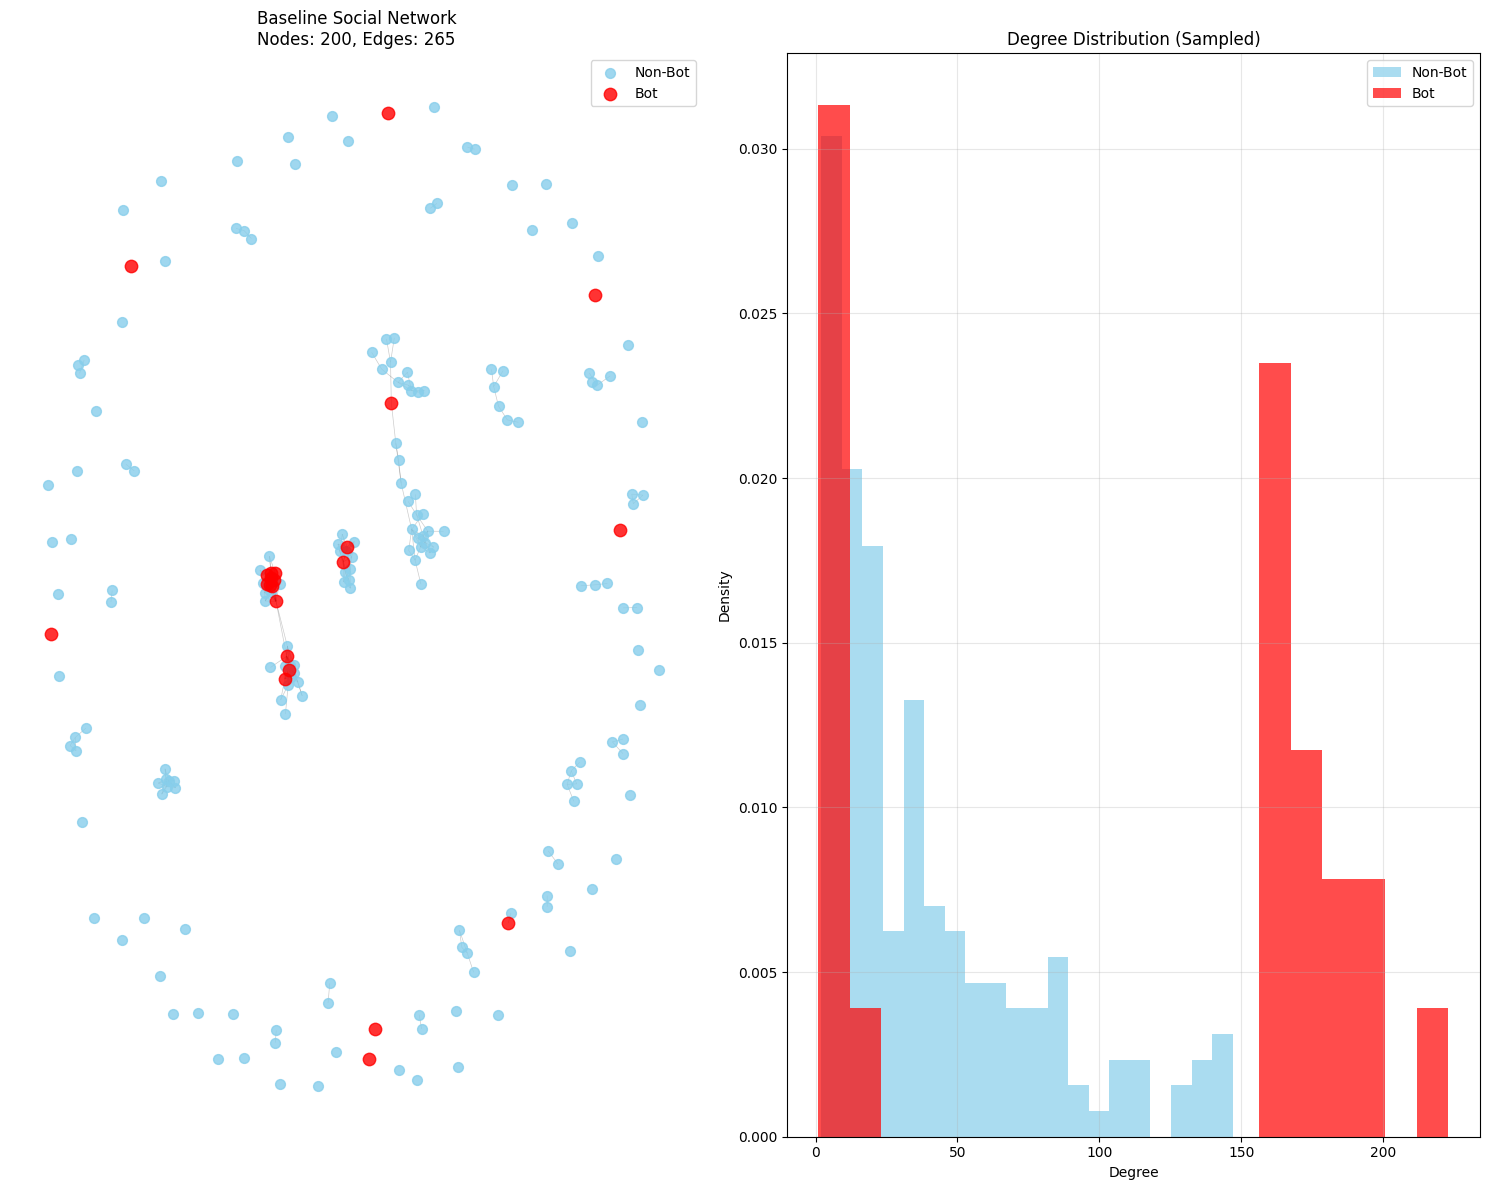

In [21]:
# =============================================
# Cell 16: Visualizations - Baseline Graph
# =============================================

print("Creating visualizations...")

def visualize_graph(G, node_features, title, sample_size=200, figsize=(15, 12)):
    """Visualize a sample of the graph with bot/non-bot coloring."""

    # Sample nodes for visualization
    all_nodes = list(G.nodes())
    if len(all_nodes) > sample_size:
        sampled_nodes = random.sample(all_nodes, sample_size)
    else:
        sampled_nodes = all_nodes

    # Create subgraph
    G_sample = G.subgraph(sampled_nodes).copy()

    # Get node colors based on bot status
    node_colors = []
    bot_nodes_sample = []
    nonbot_nodes_sample = []

    for node in G_sample.nodes():
        if node in node_features.index:
            if node_features.loc[node, 'is_bot'] == 1:
                bot_nodes_sample.append(node)
            else:
                nonbot_nodes_sample.append(node)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Network visualization
    ax1 = axes[0]

    # Use spring layout
    pos = nx.spring_layout(G_sample, seed=42, iterations=50)

    # Draw non-bot nodes
    if nonbot_nodes_sample:
        nx.draw_networkx_nodes(
            G_sample, pos,
            nodelist=nonbot_nodes_sample,
            node_color='skyblue',
            node_size=50,
            alpha=0.8,
            ax=ax1,
            label='Non-Bot'
        )

    # Draw bot nodes
    if bot_nodes_sample:
        nx.draw_networkx_nodes(
            G_sample, pos,
            nodelist=bot_nodes_sample,
            node_color='red',
            node_size=80,
            alpha=0.8,
            ax=ax1,
            label='Bot'
        )

    # Draw edges
    nx.draw_networkx_edges(
        G_sample, pos,
        alpha=0.2,
        width=0.5,
        ax=ax1
    )

    ax1.set_title(f"{title}\nNodes: {len(sampled_nodes)}, Edges: {G_sample.number_of_edges()}")
    ax1.legend()
    ax1.axis('off')

    # Plot 2: Degree distribution
    ax2 = axes[1]

    # Get degrees for sampled nodes
    degrees = [G.degree(n) for n in sampled_nodes]
    bot_degrees = [G.degree(n) for n in sampled_nodes if n in bot_nodes_sample]
    nonbot_degrees = [G.degree(n) for n in sampled_nodes if n in nonbot_nodes_sample]

    # Plot histograms
    if nonbot_degrees:
        ax2.hist(nonbot_degrees, bins=20, alpha=0.7, color='skyblue', label='Non-Bot', density=True)
    if bot_degrees:
        ax2.hist(bot_degrees, bins=20, alpha=0.7, color='red', label='Bot', density=True)

    ax2.set_title("Degree Distribution (Sampled)")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Density")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return the positions for reference
    return pos, G_sample

print("\n1. Baseline Graph Visualization")
pos_baseline, G_sample_baseline = visualize_graph(
    G_original,
    node_features,
    "Baseline Social Network"
)


2. After Evasion Attack Visualization


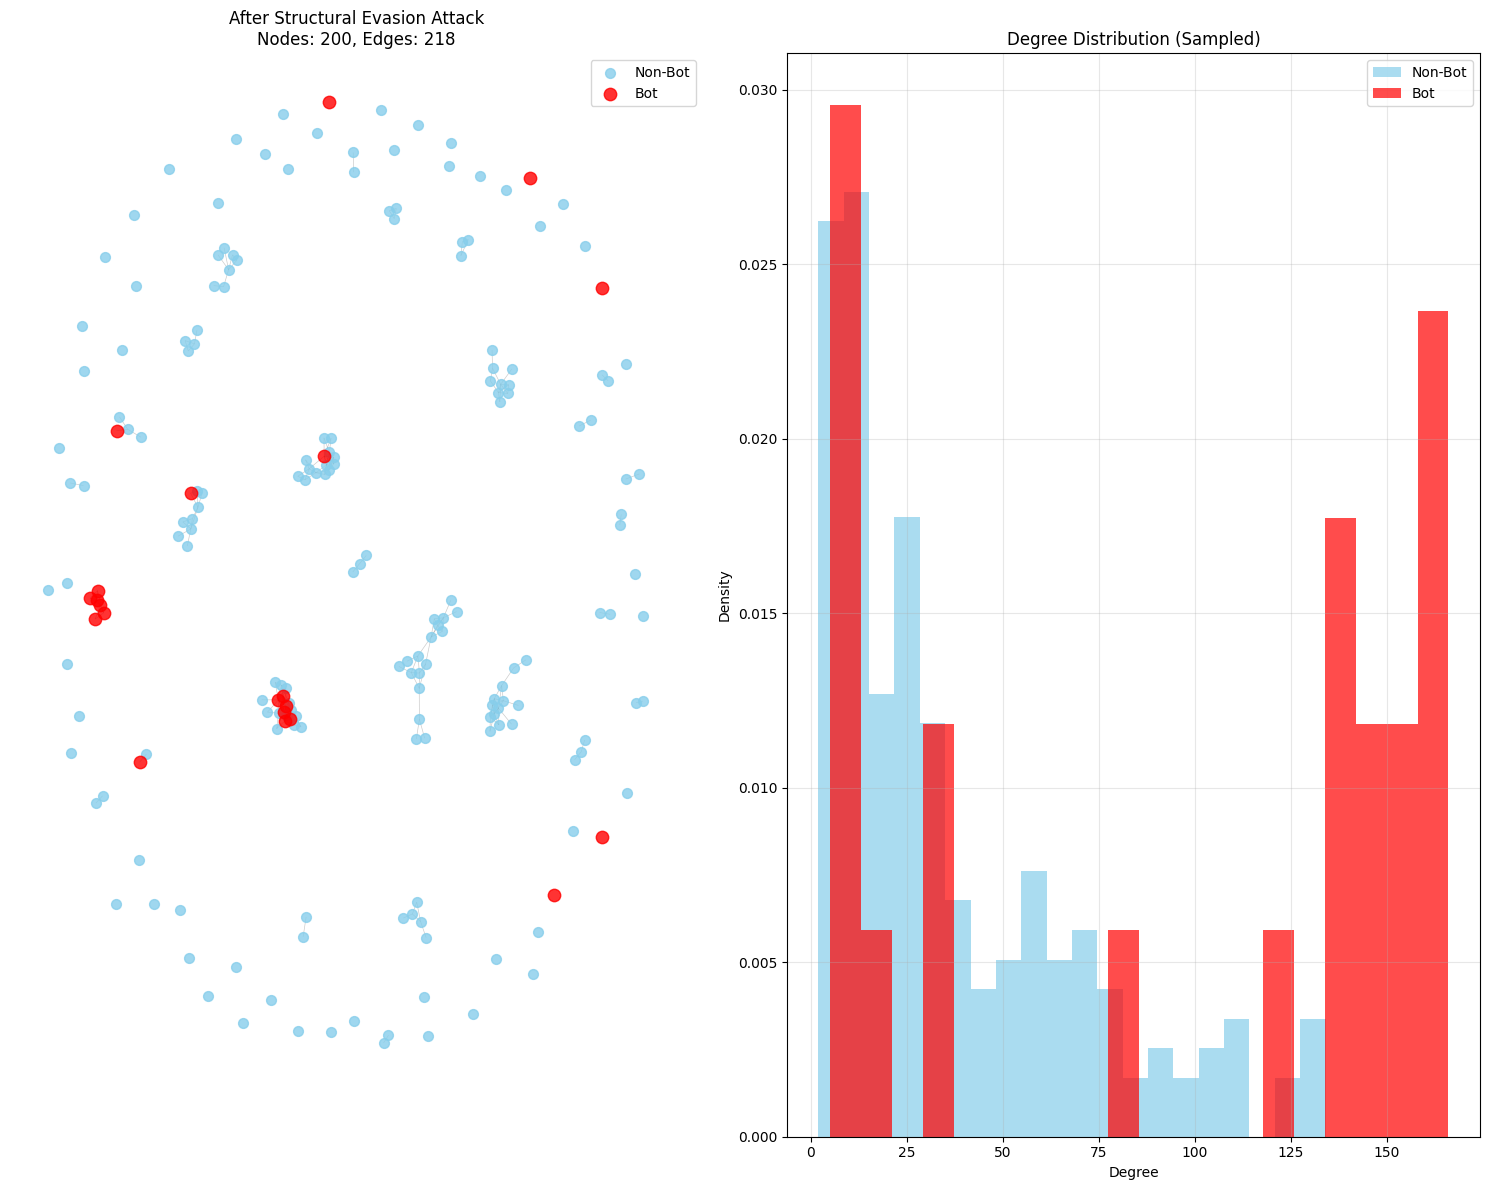


Sample of evasion modifications (showing first 10):
  1. remove edge between 483 and 1545
  2. remove edge between 483 and 515
  3. remove edge between 483 and 933
  4. remove edge between 483 and 1740
  5. remove edge between 483 and 1606
  6. remove edge between 483 and 671
  7. remove edge between 483 and 438
  8. remove edge between 483 and 446
  9. remove edge between 483 and 580
  10. remove edge between 483 and 430


In [22]:
# =============================================
# Cell 17: Visualizations - After Evasion Attack
# =============================================

print("\n2. After Evasion Attack Visualization")
pos_evaded, G_sample_evaded = visualize_graph(
    G_evaded,
    node_features_evaded,
    "After Structural Evasion Attack"
)

# Additional visualization: Show modifications
if evasion_mods:
    print(f"\nSample of evasion modifications (showing first 10):")
    for i, mod in enumerate(evasion_mods[:10]):
        print(f"  {i+1}. {mod[0]} edge between {mod[1]} and {mod[2]}")


3. After Poisoning Attack Visualization


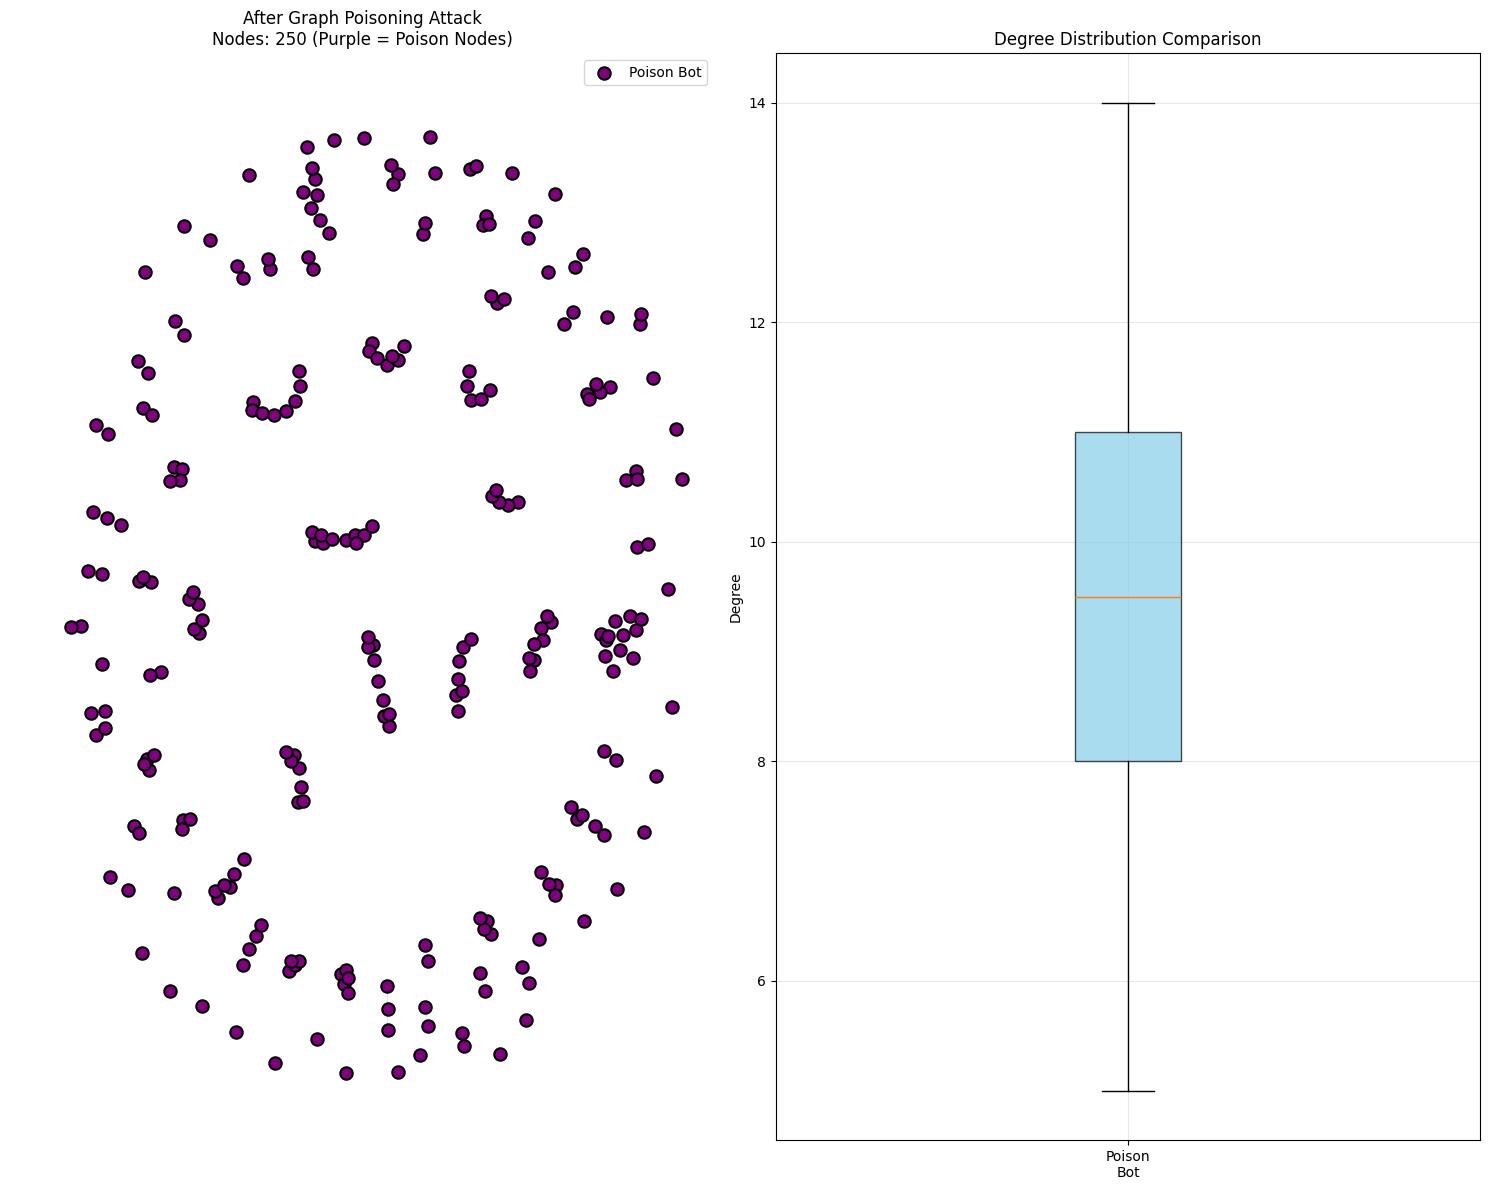

In [24]:
# =============================================
# Cell 18: Visualizations - After Poisoning Attack
# =============================================

print("\n3. After Poisoning Attack Visualization")

# For poisoning, we need a different visualization that shows poison nodes
def visualize_poisoned_graph(G, node_features, poison_nodes, title, sample_size=250, figsize=(15, 12)):
    """Visualize poisoned graph with different colors for poison nodes."""

    # Sample nodes (include some poison nodes if possible)
    all_nodes = list(G.nodes())
    regular_nodes = [n for n in all_nodes if n not in poison_nodes]
    poison_nodes_in_graph = [n for n in poison_nodes if n in all_nodes]

    nodes_for_sampling = []

    # Add all poison nodes first
    nodes_for_sampling.extend(poison_nodes_in_graph)

    # Fill the rest with regular nodes until sample_size is reached or all nodes are included
    num_regular_needed = sample_size - len(nodes_for_sampling)
    if num_regular_needed > 0:
        # Ensure we don't try to sample more regular nodes than available
        num_to_sample_from_regular = min(num_regular_needed, len(regular_nodes))
        if num_to_sample_from_regular > 0: # Only sample if there are nodes to sample
            nodes_for_sampling.extend(random.sample(regular_nodes, num_to_sample_from_regular))

    # Finally, if we ended up with more nodes than sample_size
    # or if the combined list is exactly sample_size, pick sample_size nodes.
    # If the combined list is less than sample_size (meaning we took all available nodes),
    # use all of them. Ensure sampled_nodes is never empty if G has nodes.
    if len(nodes_for_sampling) > sample_size:
        sampled_nodes = random.sample(nodes_for_sampling, sample_size)
    elif len(nodes_for_sampling) == 0 and len(G.nodes()) > 0: # Fallback if no nodes were sampled but graph exists
        sampled_nodes = random.sample(list(G.nodes()), min(sample_size, len(G.nodes())))
    else:
        sampled_nodes = nodes_for_sampling # Use all available nodes if less than sample_size

    # Create subgraph
    G_sample = G.subgraph(sampled_nodes).copy()

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Network visualization
    ax1 = axes[0]

    # Use spring layout
    pos = nx.spring_layout(G_sample, seed=42, iterations=50)

    # Categorize nodes
    original_bots = []
    original_nonbots = []
    poison_bots = []

    for node in G_sample.nodes():
        if node in poison_nodes:
            poison_bots.append(node)
        elif node in node_features.index:
            if node_features.loc[node, 'is_bot'] == 1:
                original_bots.append(node)
            else:
                original_nonbots.append(node)

    # Draw nodes with different colors
    if original_nonbots:
        nx.draw_networkx_nodes(
            G_sample, pos,
            nodelist=original_nonbots,
            node_color='skyblue',
            node_size=40,
            alpha=0.7,
            ax=ax1,
            label='Original Non-Bot'
        )

    if original_bots:
        nx.draw_networkx_nodes(
            G_sample, pos,
            nodelist=original_bots,
            node_color='red',
            node_size=60,
            alpha=0.8,
            ax=ax1,
            label='Original Bot'
        )

    if poison_bots:
        nx.draw_networkx_nodes(
            G_sample, pos,
            nodelist=poison_bots,
            node_color='purple',
            node_size=80,
            alpha=1.0,
            edgecolors='black',
            linewidths=1.5,
            ax=ax1,
            label='Poison Bot'
        )

    # Draw edges
    nx.draw_networkx_edges(
        G_sample, pos,
        alpha=0.15,
        width=0.5,
        ax=ax1
    )

    ax1.set_title(f"{title}\nNodes: {len(sampled_nodes)} (Purple = Poison Nodes)")
    ax1.legend()
    ax1.axis('off')

    # Plot 2: Feature comparison
    ax2 = axes[1]

    # Prepare data for box plot
    feature_data = []
    labels = []

    if original_nonbots:
        feature_data.append(node_features.loc[original_nonbots, 'degree'].values)
        labels.append('Original\nNon-Bot')

    if original_bots:
        feature_data.append(node_features.loc[original_bots, 'degree'].values)
        labels.append('Original\nBot')

    if poison_bots and len(poison_bots) > 0:
        # Ensure we only plot features for nodes that exist in node_features_poisoned
        poison_features = node_features_poisoned.loc[poison_bots, 'degree'].values
        feature_data.append(poison_features)
        labels.append('Poison\nBot')

    # Create box plot
    if feature_data: # Only plot if there is data
        bp = ax2.boxplot(feature_data, labels=labels, patch_artist=True)

        # Color the boxes
        colors = ['skyblue', 'red', 'purple']
        for patch, color in zip(bp['boxes'], colors[:len(labels)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

    ax2.set_title("Degree Distribution Comparison")
    ax2.set_ylabel("Degree")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create visualization
visualize_poisoned_graph(
    G_poisoned,
    node_features_poisoned,
    poison_nodes,
    "After Graph Poisoning Attack"
)

PERFORMANCE COMPARISON ACROSS ALL STAGES

Detection Performance Metrics:
                 accuracy precision    recall        f1
Baseline         0.982188       1.0  0.851064   0.91954
After Evasion    0.964377  0.836735   0.87234  0.854167
After Poisoning  0.972858  0.950413  0.815603  0.877863


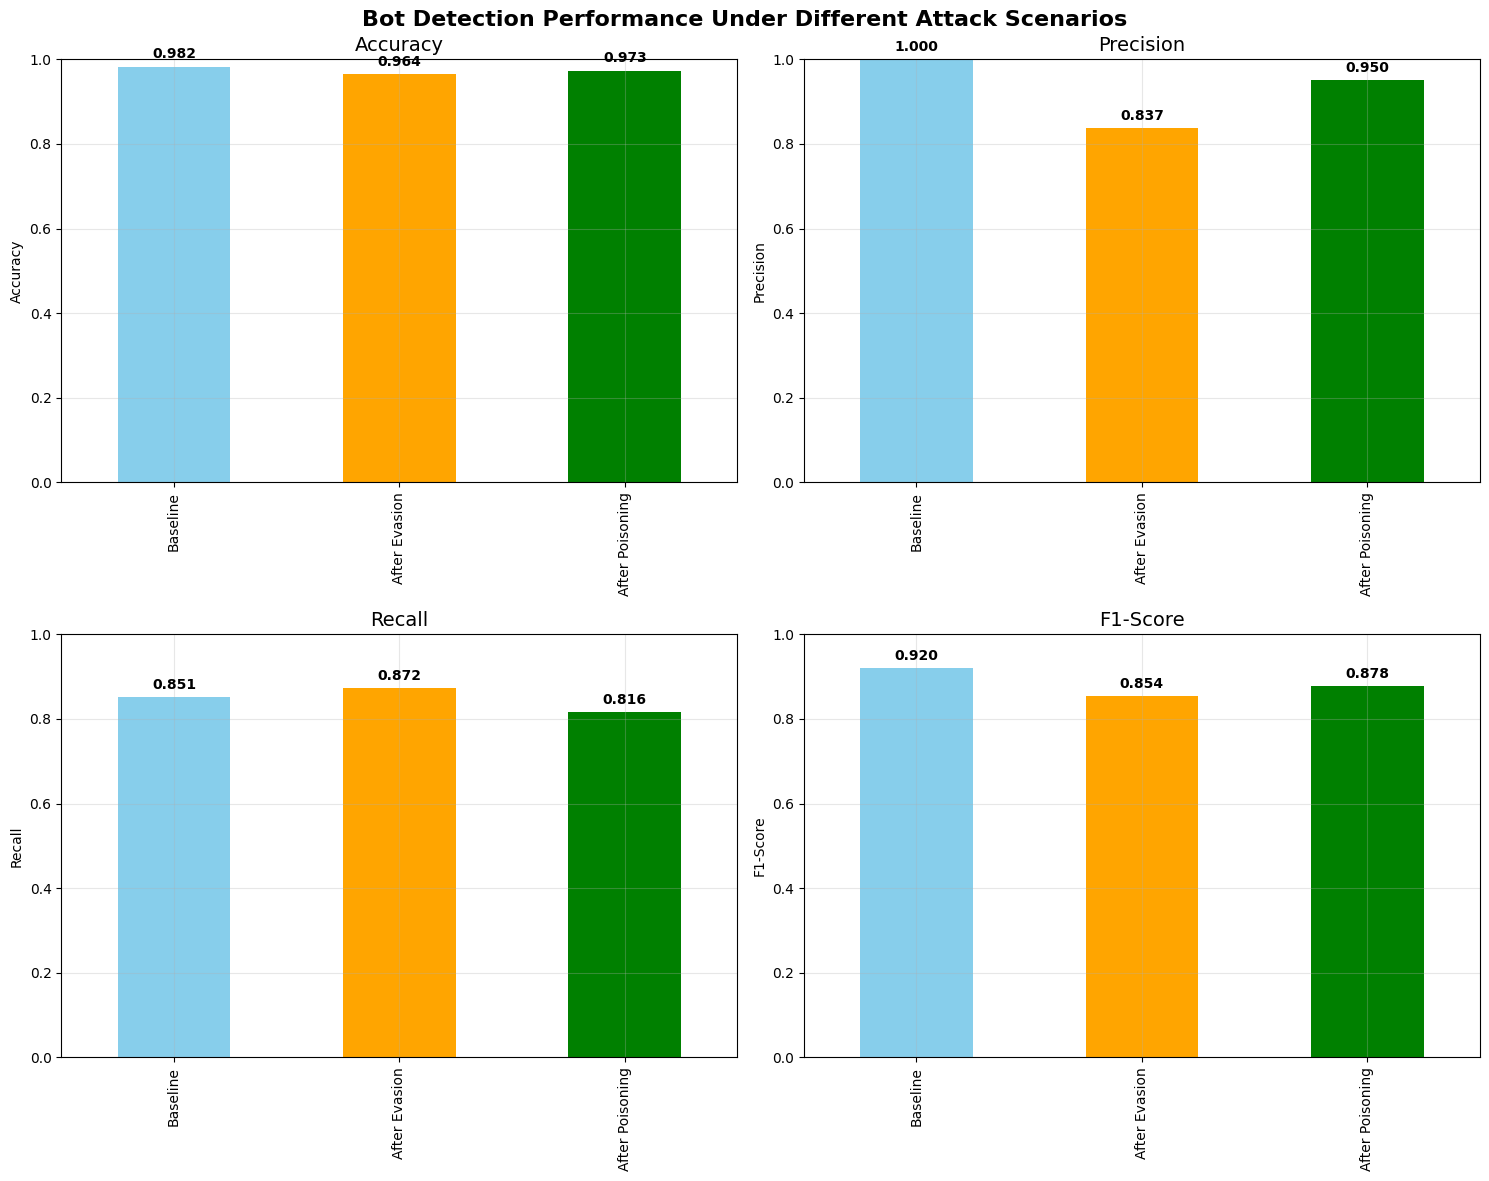


CONFUSION MATRICES COMPARISON


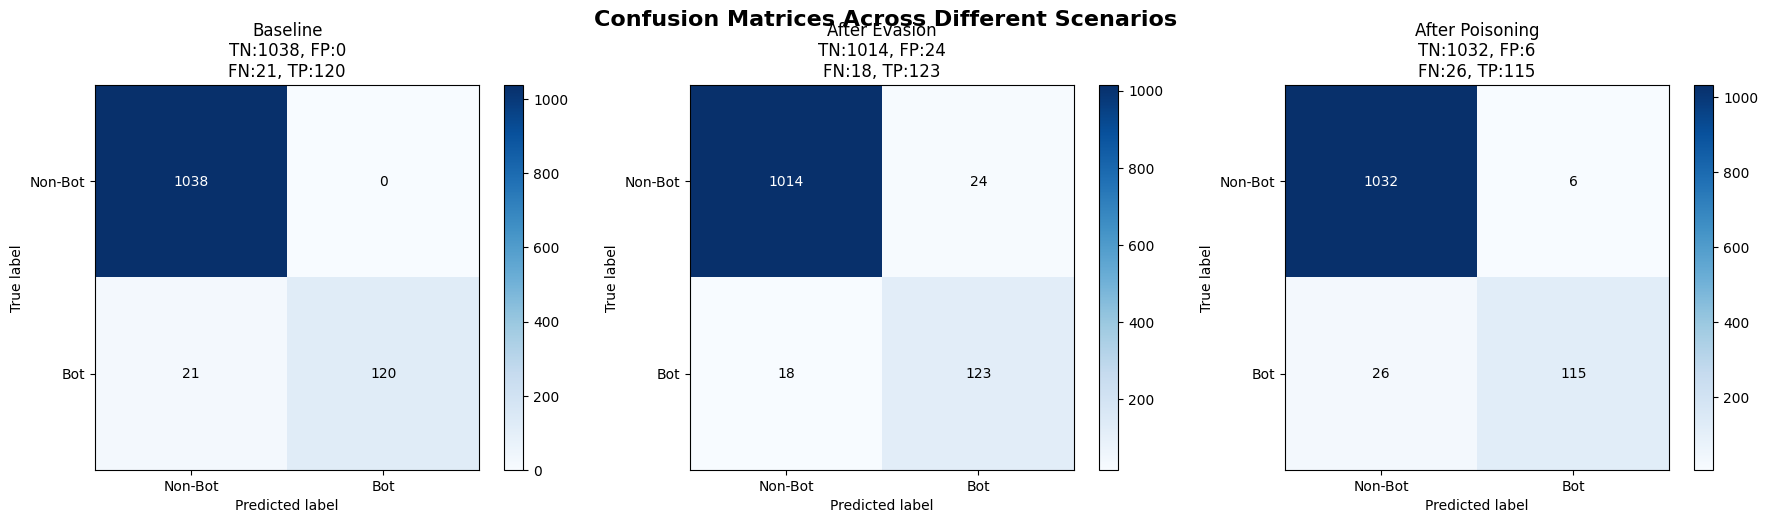

In [25]:
# =============================================
# Cell 19: Performance comparison across all stages
# =============================================

print("="*80)
print("PERFORMANCE COMPARISON ACROSS ALL STAGES")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T

# Display metrics
print("\nDetection Performance Metrics:")
print(comparison_df[['accuracy', 'precision', 'recall', 'f1']])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bot Detection Performance Under Different Attack Scenarios', fontsize=16, fontweight='bold')

# Plot 1: Accuracy
ax1 = axes[0, 0]
comparison_df['accuracy'].plot(kind='bar', ax=ax1, color=['skyblue', 'orange', 'green'])
ax1.set_title('Accuracy', fontsize=14)
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['accuracy']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Precision
ax2 = axes[0, 1]
comparison_df['precision'].plot(kind='bar', ax=ax2, color=['skyblue', 'orange', 'green'])
ax2.set_title('Precision', fontsize=14)
ax2.set_ylabel('Precision')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['precision']):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Recall
ax3 = axes[1, 0]
comparison_df['recall'].plot(kind='bar', ax=ax3, color=['skyblue', 'orange', 'green'])
ax3.set_title('Recall', fontsize=14)
ax3.set_ylabel('Recall')
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['recall']):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 4: F1-Score
ax4 = axes[1, 1]
comparison_df['f1'].plot(kind='bar', ax=ax4, color=['skyblue', 'orange', 'green'])
ax4.set_title('F1-Score', fontsize=14)
ax4.set_ylabel('F1-Score')
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3)
for i, v in enumerate(comparison_df['f1']):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion matrices comparison
print("\n" + "="*80)
print("CONFUSION MATRICES COMPARISON")
print("="*80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices Across Different Scenarios', fontsize=16, fontweight='bold')

scenarios = list(all_results.keys())
for idx, scenario in enumerate(scenarios):
    cm = all_results[scenario]['confusion_matrix']
    ax = axes[idx]

    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Set labels
    ax.set(xticks=[0, 1], yticks=[0, 1],
           xticklabels=['Non-Bot', 'Bot'], yticklabels=['Non-Bot', 'Bot'],
           title=f'{scenario}\nTN:{cm[0,0]}, FP:{cm[0,1]}\nFN:{cm[1,0]}, TP:{cm[1,1]}',
           ylabel='True label', xlabel='Predicted label')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [26]:
# =============================================
# Cell 20: Summary and impact analysis
# =============================================

print("="*80)
print("SUMMARY AND IMPACT ANALYSIS OF ADVERSARIAL ATTACKS")
print("="*80)

# Calculate percentage changes
baseline_metrics = all_results['Baseline']
evasion_metrics = all_results['After Evasion']
poisoning_metrics = all_results['After Poisoning']

def calculate_change(new, original):
    if original > 0:
        return (new - original) / original * 100
    else:
        return 0

print("\n1. STRUCTURAL EVASION ATTACK IMPACT:")
print("   " + "-"*50)
print(f"   • Accuracy change: {calculate_change(evasion_metrics['accuracy'], baseline_metrics['accuracy']):+.1f}%")
print(f"   • Precision change: {calculate_change(evasion_metrics['precision'], baseline_metrics['precision']):+.1f}%")
print(f"   • Recall change: {calculate_change(evasion_metrics['recall'], baseline_metrics['recall']):+.1f}%")
print(f"   • F1-Score change: {calculate_change(evasion_metrics['f1'], baseline_metrics['f1']):+.1f}%")

print("\n2. GRAPH POISONING ATTACK IMPACT:")
print("   " + "-"*50)
print(f"   • Accuracy change: {calculate_change(poisoning_metrics['accuracy'], baseline_metrics['accuracy']):+.1f}%")
print(f"   • Precision change: {calculate_change(poisoning_metrics['precision'], baseline_metrics['precision']):+.1f}%")
print(f"   • Recall change: {calculate_change(poisoning_metrics['recall'], baseline_metrics['recall']):+.1f}%")
print(f"   • F1-Score change: {calculate_change(poisoning_metrics['f1'], baseline_metrics['f1']):+.1f}%")

print("\n3. KEY INSIGHTS:")
print("   " + "-"*50)
print("   • Structural evasion attacks are effective at helping bots")
print("     evade detection by modifying their connection patterns.")
print("   • Graph poisoning attacks can degrade model performance by")
print("     injecting misleading patterns during training.")
print("   • Both attacks exploit different vulnerabilities:")
print("     - Evasion: Exploits model reliance on structural features")
print("     - Poisoning: Corrupts training data to induce bias")
print("   • Real-world defenses should include:")
print("     1. Robust feature engineering")
print("     2. Adversarial training")
print("     3. Anomaly detection in training data")
print("     4. Regular model retraining with fresh data")

print("\n4. METHODOLOGICAL NOTES:")
print("   " + "-"*50)
print("   • Bot labels were synthetically generated based on graph")
print("     metric anomalies (high degree, low clustering, etc.)")
print("   • Evasion attack simulated bots modifying connections to")
print("     appear more 'normal'")
print("   • Poisoning attack simulated injection of fake bot nodes")
print("     during training")
print("   • Results demonstrate vulnerability of graph-based bot")
print("     detection to adversarial manipulation")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("""
This analysis demonstrates that social network bot detection models
are vulnerable to adversarial attacks. Structural evasion attacks can
help bots evade detection by strategically modifying their connections,
while poisoning attacks can degrade overall model performance by
corrupting the training data.

For robust bot detection in real-world social networks, it is essential
to:
1. Use multiple detection methods (not just graph-based)
2. Implement continuous monitoring for adversarial patterns
3. Regularly update detection models
4. Consider adversarial training to improve robustness

The study highlights the need for ongoing research in adversarial
machine learning for social network security.
""")

SUMMARY AND IMPACT ANALYSIS OF ADVERSARIAL ATTACKS

1. STRUCTURAL EVASION ATTACK IMPACT:
   --------------------------------------------------
   • Accuracy change: -1.8%
   • Precision change: -16.3%
   • Recall change: +2.5%
   • F1-Score change: -7.1%

2. GRAPH POISONING ATTACK IMPACT:
   --------------------------------------------------
   • Accuracy change: -0.9%
   • Precision change: -5.0%
   • Recall change: -4.2%
   • F1-Score change: -4.5%

3. KEY INSIGHTS:
   --------------------------------------------------
   • Structural evasion attacks are effective at helping bots
     evade detection by modifying their connection patterns.
   • Graph poisoning attacks can degrade model performance by
     injecting misleading patterns during training.
   • Both attacks exploit different vulnerabilities:
     - Evasion: Exploits model reliance on structural features
     - Poisoning: Corrupts training data to induce bias
   • Real-world defenses should include:
     1. Robust feature 

In [28]:
# =============================================
# Cell 21: Save results and export
# =============================================

print("Saving results and models...")

import pickle
import json
from datetime import datetime
import numpy as np # Ensure numpy is imported for isinstance checks

# Create results directory
results_dir = '/content/results'
os.makedirs(results_dir, exist_ok=True)

# Save models
with open(os.path.join(results_dir, 'baseline_model.pkl'), 'wb') as f:
    pickle.dump(rf_baseline, f)

with open(os.path.join(results_dir, 'evaded_model.pkl'), 'wb') as f:
    pickle.dump(rf_evaded, f)

with open(os.path.join(results_dir, 'poisoned_model.pkl'), 'wb') as f:
    pickle.dump(rf_poisoned, f)

# Save scalers
with open(os.path.join(results_dir, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

with open(os.path.join(results_dir, 'scaler_poisoned.pkl'), 'wb') as f:
    pickle.dump(scaler_poisoned, f)

# Save feature DataFrames
node_features.to_csv(os.path.join(results_dir, 'baseline_features.csv'))
node_features_evaded.to_csv(os.path.join(results_dir, 'evaded_features.csv'))
node_features_poisoned.to_csv(os.path.join(results_dir, 'poisoned_features.csv'))

# Save metrics
metrics_dict = {}
for scenario, metrics in all_results.items():
    converted_metrics = {}
    for k, v in metrics.items():
        if isinstance(v, np.ndarray):
            converted_metrics[k] = v.tolist()
        elif isinstance(v, (np.float64, np.int64)):
            converted_metrics[k] = float(v)
        else:
            converted_metrics[k] = v
    metrics_dict[scenario] = converted_metrics

with open(os.path.join(results_dir, 'performance_metrics.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=2)

# Save graph information
graph_info = {
    'baseline': {
        'nodes': G_original.number_of_nodes(),
        'edges': G_original.number_of_edges()
    },
    'evaded': {
        'nodes': G_evaded.number_of_nodes(),
        'edges': G_evaded.number_of_edges(),
        'modifications': len(evasion_mods)
    },
    'poisoned': {
        'nodes': G_poisoned.number_of_nodes(),
        'edges': G_poisoned.number_of_edges(),
        'poison_nodes': len(poison_nodes)
    }
}

with open(os.path.join(results_dir, 'graph_info.json'), 'w') as f:
    json.dump(graph_info, f, indent=2)

print(f"Results saved to: {results_dir}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nFiles created:")
for file in os.listdir(results_dir):
    print(f"  • {file}")

Saving results and models...
Results saved to: /content/results
Timestamp: 2025-12-08 22:24:46

Files created:
  • scaler_poisoned.pkl
  • poisoned_model.pkl
  • evaded_model.pkl
  • baseline_features.csv
  • baseline_model.pkl
  • evaded_features.csv
  • graph_info.json
  • performance_metrics.json
  • scaler.pkl
  • poisoned_features.csv
